In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pv_1_2 as pv
import time

## Single PV Infinite Bus (SPVIB)

A PV with converted connected to an infinite bus through a line.

![Alt text](spvib.svg)

In [2]:
### Instantiation
model = pv.model()

## Steady state

In [3]:
### Initial state computation
params = {}
M  = 1
N  = 2
for i_m in range(1,M+1):
    for i_n in range(1,N+1):
        name = f"{i_m}".zfill(2) + f"{i_n}".zfill(2)
        params.update({f'irrad_LV{name}':1000+(np.random.rand()-0.5)*0})
        params.update({f'p_s_ppc_LV{name}':2.0,f'q_s_ppc_LV{name}':1})
        params.update({f'N_pv_s_LV{name}':20, f'N_pv_p_LV{name}':200})

#model.report_u()
#model.report_x()
#model.report_y()
model.ini(params,'xy_0.json')
model.report_y()

#model.report_params()


V_POI_MV =  1.00
theta_POI_MV =  0.00
V_POI =  1.00
theta_POI =  0.00
V_GRID =  1.00
theta_GRID =  0.00
V_LV0101 =  1.06
theta_LV0101 =  0.04
V_MV0101 =  1.02
theta_MV0101 =  0.00
V_LV0102 =  1.07
theta_LV0102 =  0.04
V_MV0102 =  1.03
theta_MV0102 =  0.00
omega_GRID =  1.00
i_d_GRID = -0.00
i_q_GRID = -0.00
p_s_GRID = -0.00
q_s_GRID = -0.00
v_dc_v_LV0101 = 674.00
i_sq_ref_LV0101 =  1.02
i_sd_ref_LV0101 =  0.95
p_s_LV0101 =  1.08
q_s_LV0101 =  1.00
v_dc_v_LV0102 = 674.00
i_sq_ref_LV0102 =  1.01
i_sd_ref_LV0102 =  0.93
p_s_LV0102 =  1.08
q_s_LV0102 =  1.00
omega_coi =  1.00
p_agc =  0.00


In [7]:
params

{'irrad_LV0101': 1000.0,
 'p_s_ppc_LV0101': 2.0,
 'q_s_ppc_LV0101': 1,
 'N_pv_s_LV0101': 20,
 'N_pv_p_LV0101': 200,
 'irrad_LV0102': 1000.0,
 'p_s_ppc_LV0102': 2.0,
 'q_s_ppc_LV0102': 1,
 'N_pv_s_LV0102': 20,
 'N_pv_p_LV0102': 200,
 'irrad_LV0103': 1000.0,
 'p_s_ppc_LV0103': 2.0,
 'q_s_ppc_LV0103': 1,
 'N_pv_s_LV0103': 20,
 'N_pv_p_LV0103': 200,
 'irrad_LV0201': 1000.0,
 'p_s_ppc_LV0201': 2.0,
 'q_s_ppc_LV0201': 1,
 'N_pv_s_LV0201': 20,
 'N_pv_p_LV0201': 200,
 'irrad_LV0202': 1000.0,
 'p_s_ppc_LV0202': 2.0,
 'q_s_ppc_LV0202': 1,
 'N_pv_s_LV0202': 20,
 'N_pv_p_LV0202': 200,
 'irrad_LV0203': 1000.0,
 'p_s_ppc_LV0203': 2.0,
 'q_s_ppc_LV0203': 1,
 'N_pv_s_LV0203': 20,
 'N_pv_p_LV0203': 200}

## Time domain simulation 

1. Change in irradiance
2. Change in temperature
3. Change in reactive power reference
4. Change in active power curtailment

In [8]:
### Time domain simulation
Δt = 0.05
model = pv.model()
model.Dt = 0.025
times = np.arange(0,5,Δt)

params = {}
for i_m in range(1,M+1):
    for i_n in range(1,N+1):
        name = f"{i_m}".zfill(2) + f"{i_n}".zfill(2)
        params.update({f'irrad_LV{name}':900+100*(np.random.rand()-0.5)})
        params.update({f'p_s_ppc_LV{name}':2.0,f'q_s_ppc_LV{name}':0})
        params.update({f'N_pv_s_LV{name}':20, f'N_pv_p_LV{name}':175})

model.ini(params,'xy_0.json')
event_1 = True
for it,t in enumerate(times):

    if t>1.0 and event_1:
        for i_m in range(1,M+1):
            for i_n in range(1,N+1):
                name = f"{i_m}".zfill(2) + f"{i_n}".zfill(2)
                irrad_0 = model.get_value(f'irrad_LV{name}')
                params.update({f'irrad_LV{name}':100+irrad_0})
        event_1 = False

    model.run(t,params)
    
model.post();

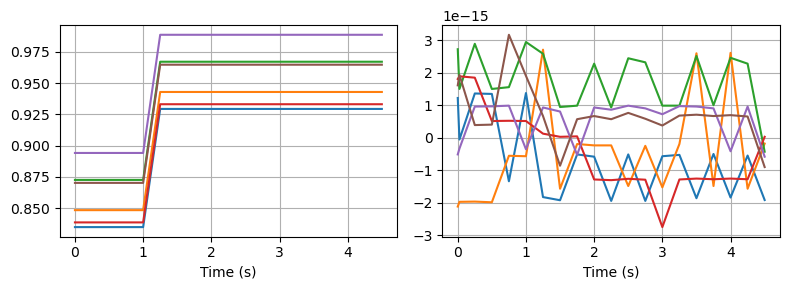

In [9]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(8, 3), dpi=100)

for i_m in range(1,M+1):
    for i_n in range(1,N+1):    
        name = 'LV' + f"{i_m}".zfill(2) + f"{i_n}".zfill(2)
        axes[0].plot(model.Time, model.get_values(f'p_s_{name}'), label=f'$p_s$')
        axes[1].plot(model.Time, model.get_values(f'q_s_{name}'), label=f'$q_s$')

#axes[1].plot(model.Time, model.get_values('v_dc_v_001'), label=r'$v_{dc}$')

for ax in axes:
    ax.grid()
    #ax.legend()
    ax.set_xlabel('Time (s)')
fig.tight_layout()

## POI voltage control

In [105]:
S_pv_plant = 1e6*N*M
SCR = 10
S_base = 100e6
U_n = 132e3

S_cc = SCR*S_pv_plant
U_base = 132e3
Z_base = U_base**2/S_base
I_base = S_base/(np.sqrt(3)*U_base)

X_cc = U_base**2/S_cc
I_cc = U_base/np.sqrt(3)/X_cc

X_cc_pu = X_cc/Z_base

b_POI_GRID = -1.0/X_cc_pu

print(f'S_cc = {S_cc/1e6:0.0f} MVA, X_cc_pu = {X_cc_pu:0.2f} pu ')


S_cc = 60 MVA, X_cc_pu = 1.67 pu 


In [106]:
I_cc

262.431940540739

In [234]:
### Time domain simulation
Δt = 0.1
model = pv.model()
model.Dt = 0.025
times = np.arange(0,11,Δt)
V_poi_ref_rec = np.copy(times)

params_ini = {'S_n_GRID':2000e6,'b_POI_GRID':b_POI_GRID}

gnames = []
for i_m in range(1,M+1):
    for i_n in range(1,N+1):    
        name = 'LV' + f"{i_m}".zfill(2) + f"{i_n}".zfill(2)
        gnames += [name]

for name in gnames:
    params_ini.update({f'irrad_{name}':800+100*(np.random.rand()-0.5)})
    params_ini.update({f'p_s_ppc_{name}':2.0,f'q_s_ppc_{name}':0})
    params_ini.update({f'N_pv_s_{name}':25, f'N_pv_p_{name}':150})

q_s_ppc_u_idxs = [  model.inputs_run_list.index(f'q_s_ppc_{name}') for name in gnames]
i_sd_ref_y_idxs = [  model.y_run_list.index(f'i_sd_ref_{name}')+model.N_x for name in gnames]
i_sq_ref_y_idxs = [  model.y_run_list.index(f'i_sq_ref_{name}')+model.N_x for name in gnames]

model.ini(params_ini,'xy_0.json')  # b_1_2 is the inverse of the line reactance (R_line = 0)

V_poi_0 = model.get_value('V_POI')
q_s_ppc_pu = 0.0
K_vp = 200
K_vi = 1000/(N*M)
xi_v = 0.0

S_pv_mva = 1.0
K_qp = 0.0
K_qi = 1/Δt*0.1
xi_q = 0.0
Q_poi_mva_0 = model.get_value('q_line_POI_GRID')*100

for it,t in enumerate(times):

    V_poi_ref = V_poi_0
    if t>1.0:
        V_poi_ref = 1.05  # change in POI voltage reference



    model.run(t,{})
    
    model.u_run[q_s_ppc_u_idxs] = q_s_ppc_pu + 0*(t)/10

    V_poi = model.get_value('V_POI')
    Q_poi_mva = model.get_value('q_line_POI_GRID')*100

    # PI POI voltage
    epsilon_v = V_poi_ref - V_poi
    xi_v += Δt*epsilon_v 
    q_poi_ref = K_vp*epsilon_v +  K_vi*xi_v

    Q_poi_mva_ref = Q_poi_mva_0
    if t>1: Q_poi_mva_ref = q_poi_ref
    # PI POI reactive power
    epsilon_q = Q_poi_mva_ref - Q_poi_mva
    xi_q += Δt*epsilon_q 
    q_ppc_mva = K_qp*epsilon_q +  K_qi*xi_q  # MVA
    q_s_ppc_pu = q_ppc_mva/(N*M)/S_pv_mva

    V_poi_ref_rec[it] = V_poi_ref

model.post();

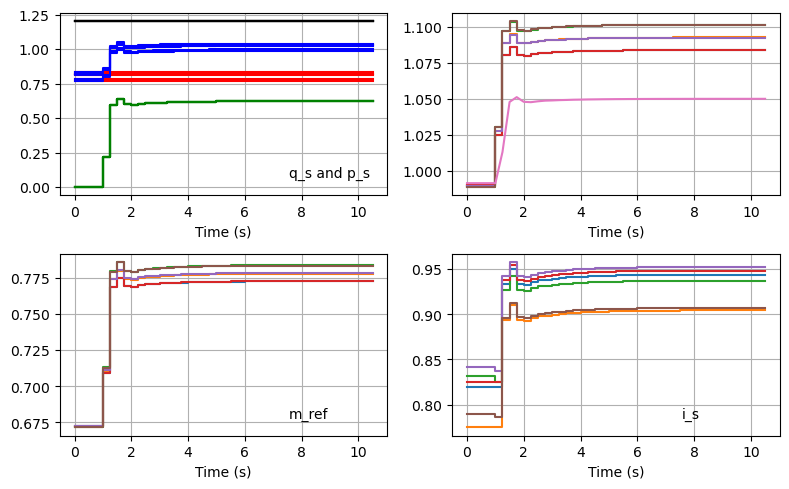

In [235]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(8, 5), dpi=100)

for it,item in enumerate(gnames):  # change in reactive power reference

    p_s =  model.get_values(f'p_s_{item}')
    q_s =  model.get_values(f'q_s_{item}')
    s_s = np.sqrt(p_s**2 + q_s**2)

    axes[0,0].step(model.Time,model.Time*0+1.2, 'k', label=f'$q_s$')

    axes[0,0].step(model.Time,p_s, 'r', label=f'$q_s$')
    axes[0,0].step(model.Time,q_s, 'g', label=f'$q_s$')
    axes[0,0].step(model.Time,s_s, 'b', label=f'$q_s$')

    axes[0,1].step(model.Time, model.get_values(f'V_{item}'), label=r'$v_{dc}$')
    axes[1,0].step(model.Time, model.get_values(f'm_ref_{item}'), label=r'$v_{dc}$')
    
    i_s = np.sqrt(model.get_values(f'i_sd_ref_{item}')**2 + model.get_values(f'i_sq_ref_{item}')**2)
    #axes[1,1].step(model.Time, model.get_values(f'v_dc_v_{item}'), label=r'$v_{dc}$')
    axes[1,1].step(model.Time, i_s, label=r'$v_{dc}$')

    #axes[0].plot(model.Time, model.get_values(f'q_s_{name}'), label=f'$q_s$')

q_s = model.get_values(f'q_s_{item}')
v_poi = model.get_values('V_POI') -1
#axes[0,1].plot(q_s**2, v_poi**2, label=r'$v_{dc}$')
#axes[0,1].plot(model.Time, model.get_values('V_GRID'), label=r'$v_{dc}$')
axes[0,1].plot(model.Time, model.get_values('V_POI'), label=r'$v_{dc}$')

labels = ['q_s and p_s','','m_ref', 'i_s']
for it,ax in enumerate(axes.flatten()):
    ax.grid()
    #ax.legend()
    ax.annotate(labels[it], xy=(0.7, 0.1), xycoords = 'axes fraction')
    ax.set_xlabel('Time (s)')
fig.tight_layout()

## Simulation performance (with step(), towards real time)

In [11]:
gen_names_list = ['LV' + f'{ig}'.zfill(3) for ig in range(1,1+N_gen)]
q_s_ppc_idxs = [  model.inputs_run_list.index(f'q_s_ppc_{name}') for name in gen_names_list]


In [143]:
model.report_z()

V_POI_MV =  1.09
V_POI =  1.09
V_GRID =  1.00
V_LV0101 =  1.14
V_MV0101 =  1.10
V_LV0102 =  1.16
V_MV0102 =  1.12
V_LV0103 =  1.17
V_MV0103 =  1.13
V_LV0201 =  1.14
V_MV0201 =  1.10
V_LV0202 =  1.16
V_MV0202 =  1.12
V_LV0203 =  1.17
V_MV0203 =  1.13
p_line_POI_GRID =  0.05
q_line_POI_GRID =  0.06
p_line_GRID_POI = -0.05
q_line_GRID_POI = -0.05
alpha_GRID =  0.00
Dv_GRID =  0.00
m_ref_LV0101 =  1.05
v_sd_LV0101 =  0.00
v_sq_LV0101 =  1.14
lvrt_LV0101 =  0.00
m_ref_LV0102 =  1.06
v_sd_LV0102 =  0.00
v_sq_LV0102 =  1.16
lvrt_LV0102 =  0.00
m_ref_LV0103 =  1.07
v_sd_LV0103 =  0.00
v_sq_LV0103 =  1.17
lvrt_LV0103 =  0.00
m_ref_LV0201 =  1.05
v_sd_LV0201 =  0.00
v_sq_LV0201 =  1.14
lvrt_LV0201 =  0.00
m_ref_LV0202 =  1.06
v_sd_LV0202 =  0.00
v_sq_LV0202 =  1.16
lvrt_LV0202 =  0.00
m_ref_LV0203 =  1.07
v_sd_LV0203 =  0.00
v_sq_LV0203 =  1.17
lvrt_LV0203 =  0.00


In [12]:
### Time domain simulation
Δt = 0.05
model = pv_100.model()
model.Dt = 0.025
times = np.arange(0,5,Δt)
V_poi_ref_rec = np.copy(times)

params_ini = {'S_n_GRID':2e6}
for ig in range(1,1+N_gen):  # change in reactive power reference
    name = 'LV' + f'{ig}'.zfill(3)
    params_ini.update({f'q_s_ppc_{name}':0})

model.ini(params_ini,'xy_0.json')  # b_1_2 is the inverse of the line reactance (R_line = 0)

V_poi_0 = model.get_value('V_POI')
q_s_ppc = 0.0
K_vp = 0.9
K_vi = 50
xi_v = 0.0
params_ctrl = {}

for it,t in enumerate(times):

    V_poi_ref = V_poi_0
    if t>1.0:
        V_poi_ref = 1.0  # change in POI voltage reference

    model.u_run[q_s_ppc_idxs] = q_s_ppc

    # if t>3.0:
    #     for ig in range(1,1+N_gen,3):  # change in reactive power reference
    #         name = 'LV' + f'{ig}'.zfill(3)
    #         params_ctrl.update({f'temp_deg_{name}':75})

    t_0 = time.perf_counter_ns()
    model.step(t,{})
    t_1 = time.perf_counter_ns()
    
    V_poi = model.get_value('V_POI')
    epsilon_v = V_poi_ref - V_poi
    xi_v += Δt*epsilon_v 
    q_s_ppc = K_vp*epsilon_v +  K_vi*xi_v
    
    V_poi_ref_rec[it] = V_poi_ref

    print(f't = {t:4.2f} s, time = {(t_1-t_0)/1e6:4.0f} ms, V_poi = {V_poi:3.2f}')

t = 0.00 s, time =  847 ms, V_poi = 1.00
t = 0.05 s, time =    0 ms, V_poi = 1.00
t = 0.10 s, time =    0 ms, V_poi = 1.00
t = 0.15 s, time =    0 ms, V_poi = 1.00
t = 0.20 s, time =    0 ms, V_poi = 1.00
t = 0.25 s, time =    0 ms, V_poi = 1.00
t = 0.30 s, time =    0 ms, V_poi = 1.00
t = 0.35 s, time =    0 ms, V_poi = 1.00
t = 0.40 s, time =    0 ms, V_poi = 1.00
t = 0.45 s, time =    0 ms, V_poi = 1.00
t = 0.50 s, time =    0 ms, V_poi = 1.00
t = 0.55 s, time =    0 ms, V_poi = 1.00
t = 0.60 s, time =    0 ms, V_poi = 1.00
t = 0.65 s, time =    0 ms, V_poi = 1.00
t = 0.70 s, time =    0 ms, V_poi = 1.00
t = 0.75 s, time =    1 ms, V_poi = 1.00
t = 0.80 s, time =    0 ms, V_poi = 1.00
t = 0.85 s, time =    0 ms, V_poi = 1.00
t = 0.90 s, time =    0 ms, V_poi = 1.00
t = 0.95 s, time =    0 ms, V_poi = 1.00
t = 1.00 s, time =    0 ms, V_poi = 1.00
t = 1.05 s, time =    1 ms, V_poi = 1.00
t = 1.10 s, time =    1 ms, V_poi = 1.00
t = 1.15 s, time =    1 ms, V_poi = 1.00
t = 1.20 s, time

## LVRT 

In [29]:
### Time domain simulation
Δt = 0.2
model = pv_100.model()
model.Dt = 0.05
times = np.arange(0,5,Δt)
V_poi_ref_rec = np.copy(times)

params_ini = {'S_n_GRID':100e6}

for ig in range(1,1+N_gen):  # change in reactive power reference
    name = 'LV' + f'{ig}'.zfill(3)
    params_ini.update({f'q_s_ppc_{name}':0})
    params_ini.update({f'v_lvrt_{name}':0})

gen_names_list = ['LV' + f'{ig}'.zfill(3) for ig in range(1,1+N_gen)]
V_y_idxs = [  model.y_run_list.index(f'V_{name}') for name in gen_names_list]
lvrt_ext_y_idxs = [  model.inputs_run_list.index(f'lvrt_ext_{name}') for name in gen_names_list]
v_lvrt_idxs = [  model.params_list.index(f'v_lvrt_{name}') for name in gen_names_list]


model.ini(params_ini,'xy_0.json')  # b_1_2 is the inverse of the line reactance (R_line = 0)

i_sr_ref_1 = 1.0
params_ctrl = {}
for it,t in enumerate(times):

    v_ref_GRID = 1.0
    if t>1.0:
        v_ref_GRID = 0.8 # change in Grid voltage reference
    if t>1.2:
        v_ref_GRID = 0.8  # change in Grid voltage reference
    if t>3.0:
        for ig in range(1,1+N_gen,3):  # change in reactive power reference
            name = 'LV' + f'{ig}'.zfill(3)
            params_ctrl.update({f'i_sr_ref_{name}':0.0})

    params_ctrl.update({'v_ref_GRID':v_ref_GRID})

    ### LVRT algorithm
    V_LV = model.xy[np.array(V_y_idxs)+model.N_x]
    lvrt_ext = np.zeros(N_gen)
    lvrt_ext[V_LV < 0.8] = 1.0
    model.u_run[lvrt_ext_y_idxs] = lvrt_ext
    
    ### run
    model.run(t,{})

model.post();

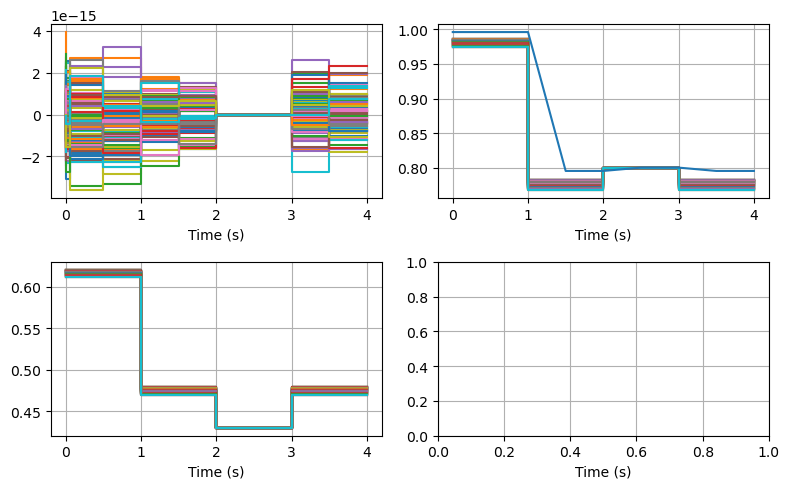

In [27]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(8, 5), dpi=100)

for it in range(1,1+N_gen):  # change in reactive power reference
    name = 'LV' + f'{it}'.zfill(3)
    axes[0,0].step(model.Time, model.get_values(f'q_s_{name}'), label=f'$p_s$')
    axes[0,1].step(model.Time, model.get_values(f'V_{name}'), label=r'$v_{dc}$')
    axes[1,0].step(model.Time, model.get_values(f'm_ref_{name}'), label=r'$v_{dc}$')
    #axes[1,1].step(model.Time, model.get_values(f'v_dc_v_{name}'), label=r'$v_{dc}$')
    # axes[1,1].step(model.Time, model.get_values(f'i_sr_{name}'), label=r'$v_{dc}$')
    # axes[1,1].step(model.Time, model.get_values(f'i_si_{name}'), label=r'$v_{dc}$')

    #axes[0].plot(model.Time, model.get_values(f'q_s_{name}'), label=f'$q_s$')

axes[0,1].plot(model.Time, model.get_values('V_POI'), label=r'$v_{dc}$')

for ax in axes.flatten():
    ax.grid()
    #ax.legend()
    ax.set_xlabel('Time (s)')
ax.set_xlabel('Time (s)')
fig.tight_layout()

In [28]:
params_ctrl

{'v_ref_GRID': 0.8,
 'i_sr_ref_LV001': 0.0,
 'i_sr_ref_LV004': 0.0,
 'i_sr_ref_LV007': 0.0,
 'i_sr_ref_LV010': 0.0,
 'i_sr_ref_LV013': 0.0,
 'i_sr_ref_LV016': 0.0,
 'i_sr_ref_LV019': 0.0,
 'i_sr_ref_LV022': 0.0,
 'i_sr_ref_LV025': 0.0,
 'i_sr_ref_LV028': 0.0,
 'i_sr_ref_LV031': 0.0,
 'i_sr_ref_LV034': 0.0,
 'i_sr_ref_LV037': 0.0,
 'i_sr_ref_LV040': 0.0,
 'i_sr_ref_LV043': 0.0,
 'i_sr_ref_LV046': 0.0,
 'i_sr_ref_LV049': 0.0,
 'i_sr_ref_LV052': 0.0,
 'i_sr_ref_LV055': 0.0,
 'i_sr_ref_LV058': 0.0,
 'i_sr_ref_LV061': 0.0,
 'i_sr_ref_LV064': 0.0,
 'i_sr_ref_LV067': 0.0,
 'i_sr_ref_LV070': 0.0,
 'i_sr_ref_LV073': 0.0,
 'i_sr_ref_LV076': 0.0,
 'i_sr_ref_LV079': 0.0,
 'i_sr_ref_LV082': 0.0,
 'i_sr_ref_LV085': 0.0,
 'i_sr_ref_LV088': 0.0,
 'i_sr_ref_LV091': 0.0,
 'i_sr_ref_LV094': 0.0,
 'i_sr_ref_LV097': 0.0,
 'i_sr_ref_LV100': 0.0}